## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import AlbertTokenizer
import transformers

from text_data import TextDataset5
from albert import CustomAlbert
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

In [3]:
%%time
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 11.8 s, sys: 116 ms, total: 11.9 s
Wall time: 12.2 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2
TextDataset = TextDataset5

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_albert_2'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.q_albert, lr / 100, weight_decay)
        + get_optimizer_param_groups(model.a_albert, lr / 100, weight_decay)
    )

There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


Fold 1 started at Fri Feb  7 19:01:10 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


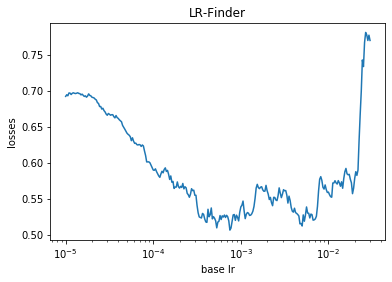

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49458 - spearmanr 0.28816
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47018 - spearmanr 0.39492


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.39492
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.47173 - spearmanr 0.35101
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45908 - spearmanr 0.40433
best model: epoch 1 - 0.40433
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44163 - spearmanr 0.43857
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44974 - spearmanr 0.42107
best model: epoch 2 - 0.42107
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40667 - spearmanr 0.5242
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45575 - spearmanr 0.41506
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42107
Starting inference for model: checkpoints/siamese_albert_2_fold_1_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_1_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 2 started at Fri Feb  7 19:40:14 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49516 - spearmanr 0.28538
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47023 - spearmanr 0.38474
best model: epoch 0 - 0.38474
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46297 - spearmanr 0.36198
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.47013 - spearmanr 0.37823
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44238 - spearmanr 0.42012
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45546 - spearmanr 0.41267
best model: epoch 2 - 0.41267
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41791 - spearmanr 0.48683
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45505 - spearmanr 0.412
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41267
Starting inference for model: checkpoints/siamese_albert_2_fold_2_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_2_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 3 started at Fri Feb  7 20:17:57 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49566 - spearmanr 0.28619
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48095 - spearmanr 0.31943
best model: epoch 0 - 0.31943
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46625 - spearmanr 0.35451
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4645 - spearmanr 0.39336
best model: epoch 1 - 0.39336
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44405 - spearmanr 0.42147
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45769 - spearmanr 0.3981
best model: epoch 2 - 0.3981
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42074 - spearmanr 0.48426
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45808 - spearmanr 0.39809
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39810
Starting inference for model: checkpoints/siamese_albert_2_fold_3_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_3_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 4 started at Fri Feb  7 20:56:14 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49404 - spearmanr 0.2887
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47176 - spearmanr 0.36638
best model: epoch 0 - 0.36638
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45804 - spearmanr 0.3908
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45696 - spearmanr 0.39312
best model: epoch 1 - 0.39312
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.4317 - spearmanr 0.46167
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45398 - spearmanr 0.40095
best model: epoch 2 - 0.40095
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.39524 - spearmanr 0.54807
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45906 - spearmanr 0.39848
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40095
Starting inference for model: checkpoints/siamese_albert_2_fold_4_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_4_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 5 started at Fri Feb  7 21:34:38 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49511 - spearmanr 0.2894
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46441 - spearmanr 0.37357
best model: epoch 0 - 0.37357
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.459 - spearmanr 0.3877
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45713 - spearmanr 0.39374
best model: epoch 1 - 0.39374
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43596 - spearmanr 0.45298
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45185 - spearmanr 0.40267
best model: epoch 2 - 0.40267
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40073 - spearmanr 0.53678
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45868 - spearmanr 0.40195
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40267
Starting inference for model: checkpoints/siamese_albert_2_fold_5_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_5_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 6 started at Fri Feb  7 22:13:24 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49719 - spearmanr 0.28244
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47129 - spearmanr 0.31884
best model: epoch 0 - 0.31884
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.48059 - spearmanr 0.31754
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45721 - spearmanr 0.37693
best model: epoch 1 - 0.37693
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.45084 - spearmanr 0.40752
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44891 - spearmanr 0.40042
best model: epoch 2 - 0.40042
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42747 - spearmanr 0.4703
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44789 - spearmanr 0.40454
best model: epoch 3 - 0.40454
TRAINING END: Best score achieved on epoch 3 - 0.40454
Starting inference for model: checkpoints/siamese_albert_2_fold_6_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_6_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 7 started at Fri Feb  7 22:51:53 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49473 - spearmanr 0.28874
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.4737 - spearmanr 0.37435
best model: epoch 0 - 0.37435
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45807 - spearmanr 0.38724
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46438 - spearmanr 0.3956
best model: epoch 1 - 0.3956
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43163 - spearmanr 0.46078
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.46197 - spearmanr 0.40627
best model: epoch 2 - 0.40627
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.39475 - spearmanr 0.54784
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46908 - spearmanr 0.40092
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40627
Starting inference for model: checkpoints/siamese_albert_2_fold_7_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_7_best.pth



Fold 8 started at Fri Feb  7 23:30:18 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.
There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49521 - spearmanr 0.28413
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47586 - spearmanr 0.37634
best model: epoch 0 - 0.37634
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45748 - spearmanr 0.38584
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46552 - spearmanr 0.40792
best model: epoch 1 - 0.40792
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43165 - spearmanr 0.45976
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45961 - spearmanr 0.4205
best model: epoch 2 - 0.4205
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.3941 - spearmanr 0.54837
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46848 - spearmanr 0.41545
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42050
Starting inference for model: checkpoints/siamese_albert_2_fold_8_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_8_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 9 started at Sat Feb  8 00:08:45 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49441 - spearmanr 0.28715
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46567 - spearmanr 0.37395
best model: epoch 0 - 0.37395
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45941 - spearmanr 0.38392
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45724 - spearmanr 0.40302
best model: epoch 1 - 0.40302
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44404 - spearmanr 0.41363
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45618 - spearmanr 0.38484
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41812 - spearmanr 0.48653
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45295 - spearmanr 0.40188
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 1 - 0.40302
Starting inference for model: checkpoints/siamese_albert_2_fold_9_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_9_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 10 started at Sat Feb  8 00:47:39 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49749 - spearmanr 0.28082
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46405 - spearmanr 0.38994
best model: epoch 0 - 0.38994
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.47801 - spearmanr 0.33554
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.47068 - spearmanr 0.35595
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.45884 - spearmanr 0.39574
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.46966 - spearmanr 0.35834
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.43449 - spearmanr 0.46604
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46871 - spearmanr 0.36945
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 0 - 0.38994
Starting inference for model: checkpoints/siamese_albert_2_fold_10_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_10_best.pth



OOF score: 0.39909062603347


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomAlbert(256, cat_features_train.shape[1], head_dropout=0.2)
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [12]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 8 0.46366214594210364
5 4 0.4372745196529576
7 8 0.4817853734788858
9 64 0.1323598823545707
11 8 0.7462959881283096
12 4 0.49428509853286545
13 16 0.17987642668067666
14 4 0.6002115151135229
15 4 0.5576431725948969
19 16 0.1725570116081954
23 16 0.15250562932977896


In [13]:
np.array(opt_ds), np.array(opt_indices)

(array([ 8,  4,  8, 64,  8,  4, 16,  4,  4, 16, 16]),
 array([ 2,  5,  7,  9, 11, 12, 13, 14, 15, 19, 23]))

In [14]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [15]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.399091
CV unique rows,0.367830
CV ignoring hard targets,0.421474
CV unique rows ignoring hard targets,0.387445
CV w rounding,0.424713
CV unique rows w rounding,0.401177
CV ignoring hard targets w rounding,0.444159
CV unique rows ignoring hard targets w rounding,0.414645


In [16]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.403055
CV unique rows,0.371913
CV ignoring hard targets,0.421474
CV unique rows ignoring hard targets,0.387445
CV w rounding,0.425141
CV unique rows w rounding,0.402189
CV ignoring hard targets w rounding,0.444159
CV unique rows ignoring hard targets w rounding,0.414645


In [17]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [18]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.773230,0.531518,0.399149,0.446468,0.522681,0.450889,0.666663,0.692489,0.660838,0.004828,0.668963,0.794378,0.022827,0.168694,0.009653,0.044200,0.050016,0.118335,0.832166,0.000945,0.776002,0.597679,0.321529,0.762896,0.798205,0.396172,0.018547,0.043101,0.882019,0.678643
1,46,0.485451,0.241967,0.010046,0.665582,0.684906,0.849430,0.388477,0.272261,0.231857,0.007026,0.476039,0.603739,0.007841,0.001993,0.001827,0.012420,0.807401,0.370288,0.172545,0.000245,0.341180,0.741508,0.488091,0.817667,0.881496,0.549317,0.866648,0.327189,0.123340,0.559561
2,70,0.631462,0.604205,0.057916,0.690299,0.820794,0.859498,0.519830,0.413853,0.155660,0.007393,0.239061,0.753676,0.032983,0.098465,0.010098,0.020504,0.120488,0.122958,0.660215,0.001905,0.730060,0.560883,0.319670,0.731133,0.713373,0.389235,0.053873,0.077226,0.858517,0.590301
3,132,0.557513,0.209672,0.008136,0.653931,0.622253,0.849646,0.385733,0.243130,0.196000,0.013540,0.555068,0.093011,0.003042,0.002098,0.000932,0.009728,0.827775,0.321783,0.520637,0.000155,0.376130,0.810436,0.567744,0.881421,0.910316,0.651577,0.825789,0.313695,0.575531,0.606024
4,200,0.748869,0.210116,0.072700,0.755596,0.707630,0.810547,0.627289,0.619416,0.256888,0.028099,0.395394,0.501014,0.020268,0.031237,0.020139,0.102003,0.154593,0.128240,0.656677,0.004210,0.424190,0.656772,0.490106,0.820919,0.808547,0.518503,0.232929,0.156654,0.587614,0.615694


In [19]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [20]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.788319,0.768889,0.110876,0.469933,0.775864,0.661200,0.507366,0.374797,0.241487,0.004485,0.359587,0.013744,0.179500,0.048760,0.015779,0.159210,0.212600,0.204830,0.613047,0.000537,0.826371,0.719342,0.484372,0.820037,0.786598,0.566838,0.196820,0.174518,0.796396,0.759960
1,0.866248,0.749002,0.108417,0.566281,0.912529,0.641783,0.562255,0.683242,0.380951,0.001004,0.344092,0.095314,0.932534,0.016619,0.615789,0.028805,0.016961,0.040012,0.449850,0.011048,0.814170,0.645640,0.341033,0.730060,0.842728,0.410980,0.022575,0.064409,0.474980,0.701488
2,0.470373,0.177437,0.018468,0.585409,0.764540,0.763850,0.389259,0.204139,0.227345,0.018299,0.373635,0.110376,0.043755,0.009822,0.009124,0.432712,0.607325,0.337456,0.338089,0.000833,0.383578,0.837905,0.550582,0.897860,0.918699,0.620216,0.529925,0.375520,0.660610,0.685434
3,0.741693,0.682075,0.132659,0.754046,0.805550,0.769382,0.581062,0.588755,0.355263,0.003441,0.316878,0.915881,0.042946,0.098090,0.085670,0.041699,0.071525,0.147236,0.569377,0.010546,0.776017,0.636932,0.604852,0.802740,0.761339,0.575556,0.104451,0.205786,0.821433,0.626114
4,0.817297,0.695077,0.003662,0.733730,0.850645,0.918577,0.511710,0.418628,0.310719,0.000685,0.223302,0.570320,0.001445,0.001466,0.001789,0.007497,0.857239,0.341220,0.113719,0.000094,0.796810,0.589767,0.340337,0.710095,0.721836,0.464752,0.796521,0.240662,0.060791,0.498603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.869884,0.565006,0.139583,0.745142,0.756853,0.731143,0.702562,0.762386,0.495025,0.004808,0.384146,0.904087,0.040526,0.105707,0.042124,0.073705,0.073037,0.139102,0.456440,0.013459,0.803101,0.772697,0.638778,0.828217,0.859877,0.662108,0.063215,0.097606,0.826145,0.748088
6075,0.768532,0.300262,0.112878,0.456714,0.524467,0.426329,0.647378,0.597705,0.101604,0.005565,0.654518,0.020565,0.020006,0.002495,0.001575,0.035334,0.806678,0.379758,0.161554,0.000238,0.614705,0.775489,0.560304,0.889141,0.888749,0.594262,0.793303,0.427392,0.329626,0.734457
6076,0.749407,0.549381,0.008709,0.835888,0.693601,0.907995,0.496477,0.396062,0.137740,0.001467,0.339239,0.680600,0.007135,0.001782,0.001433,0.019879,0.761677,0.278390,0.059475,0.000199,0.542470,0.830741,0.488632,0.889420,0.900360,0.626324,0.699830,0.192035,0.276711,0.579129
6077,0.787279,0.406439,0.365626,0.389309,0.523247,0.335570,0.599382,0.660215,0.918637,0.005791,0.755081,0.622992,0.179880,0.140936,0.103564,0.259124,0.122345,0.369132,0.752125,0.003309,0.733000,0.625322,0.522275,0.755202,0.743146,0.436426,0.021389,0.135386,0.790008,0.786330


In [21]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.364084
question_body_critical                   0.662178
question_conversational                  0.395415
question_expect_short_answer             0.261644
question_fact_seeking                    0.338622
question_has_commonly_accepted_answer    0.405372
question_interestingness_others          0.353176
question_interestingness_self            0.479035
question_multi_intent                    0.573053
question_not_really_a_question           0.104968
question_opinion_seeking                 0.440880
question_type_choice                     0.736109
question_type_compare                    0.350110
question_type_consequence                0.165250
question_type_definition                 0.353108
question_type_entity                     0.444910
question_type_instructions               0.770111
question_type_procedure                  0.341874
question_type_reason_explanation         0.646953
question_type_spelling                   0.066484


In [22]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.066484,3.0
question_not_really_a_question,0.104968,5.0
answer_plausible,0.149036,9.0
question_type_consequence,0.165250,5.0
answer_relevance,0.183778,9.0
answer_well_written,0.184164,9.0
answer_helpful,0.239949,9.0
question_expect_short_answer,0.261644,5.0
answer_type_procedure,0.292237,5.0
answer_satisfaction,0.324241,17.0


In [23]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'question_type_consequence', 'answer_relevance'],
      dtype='object')

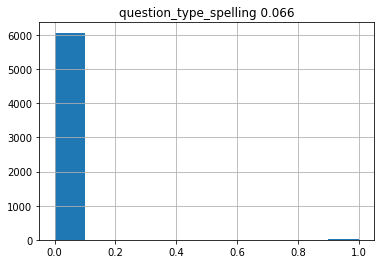

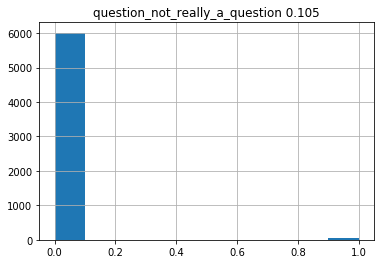

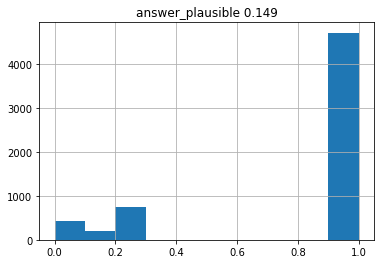

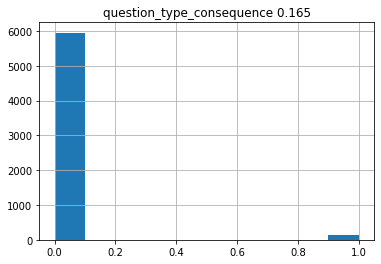

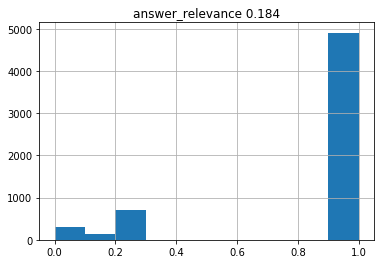

In [24]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


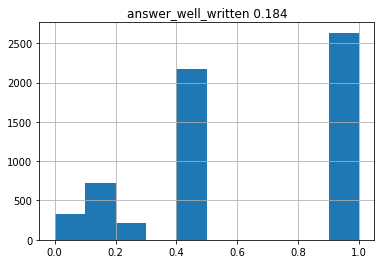

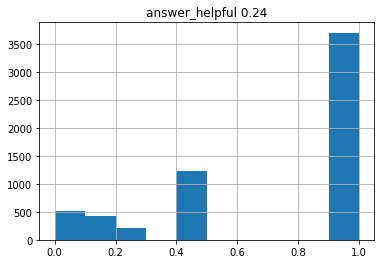

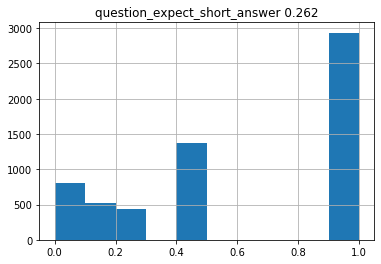

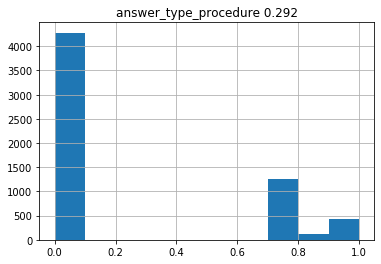

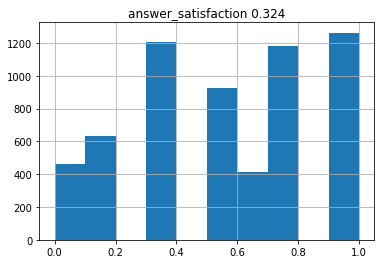

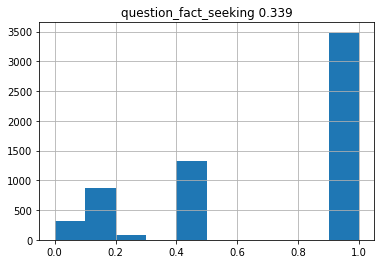

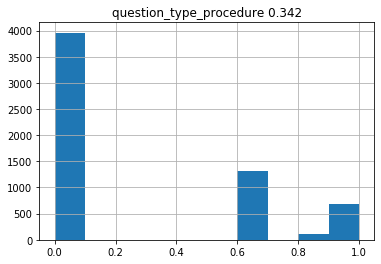

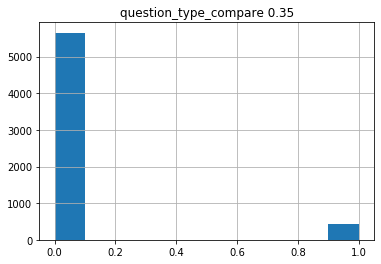

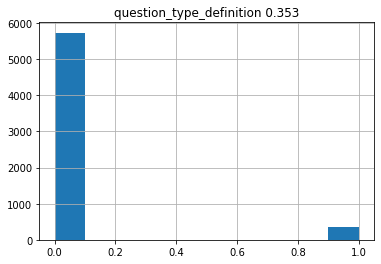

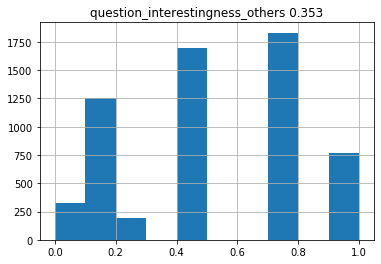

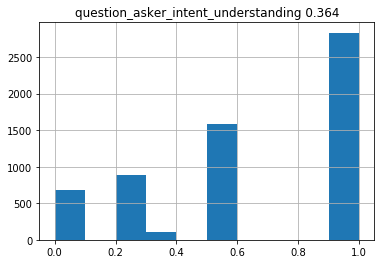

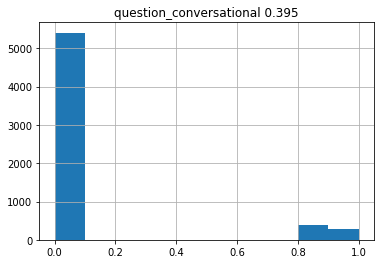

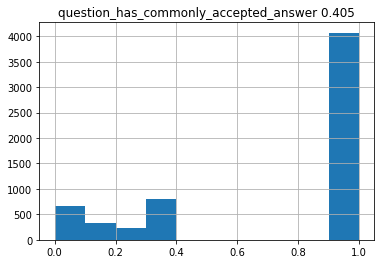

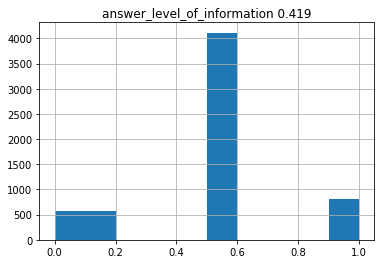

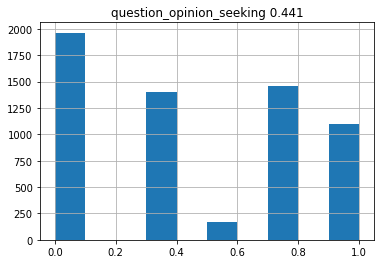

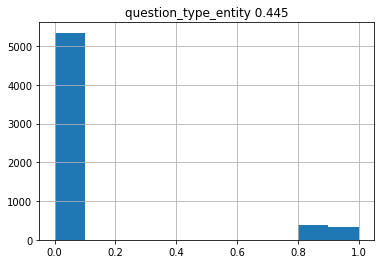

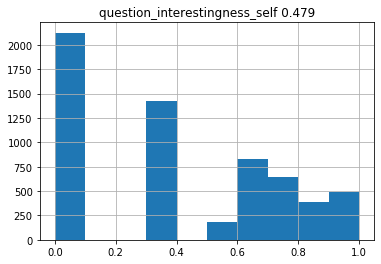

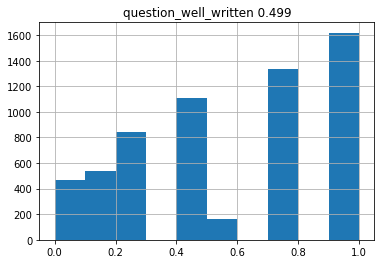

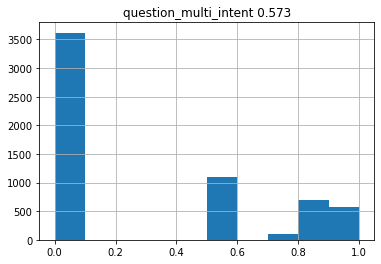

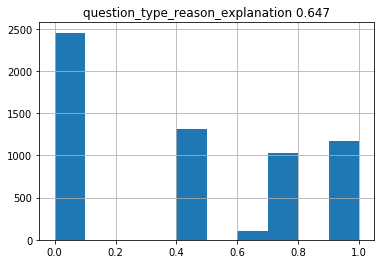

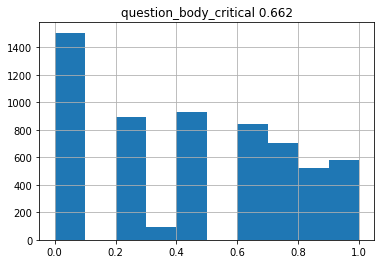

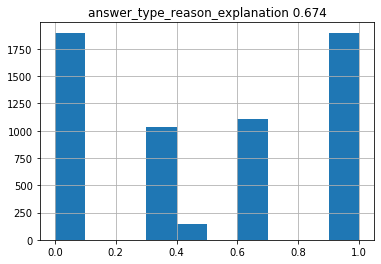

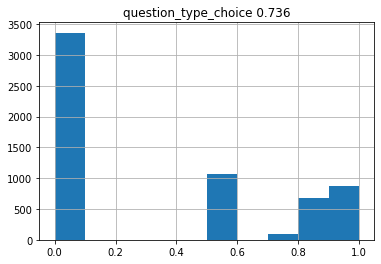

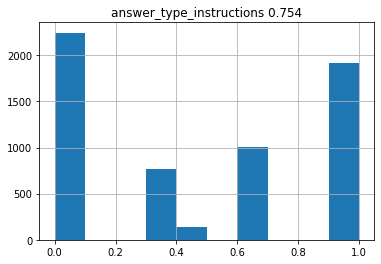

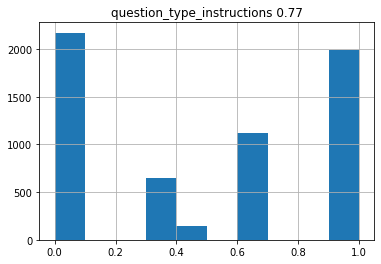

In [25]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')